In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from sklearn.metrics import r2_score 

# Step1: Reading and understanding the data

## 1.1 Reading and basic checks

In [96]:
boombikes=pd.read_csv('day.csv')

In [97]:
boombikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [98]:
boombikes.shape

(730, 16)

In [99]:
boombikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


**`No null values and no other column anomalies, so data cleaning can be skipped`**

In [100]:
boombikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


## 1.2 EDA

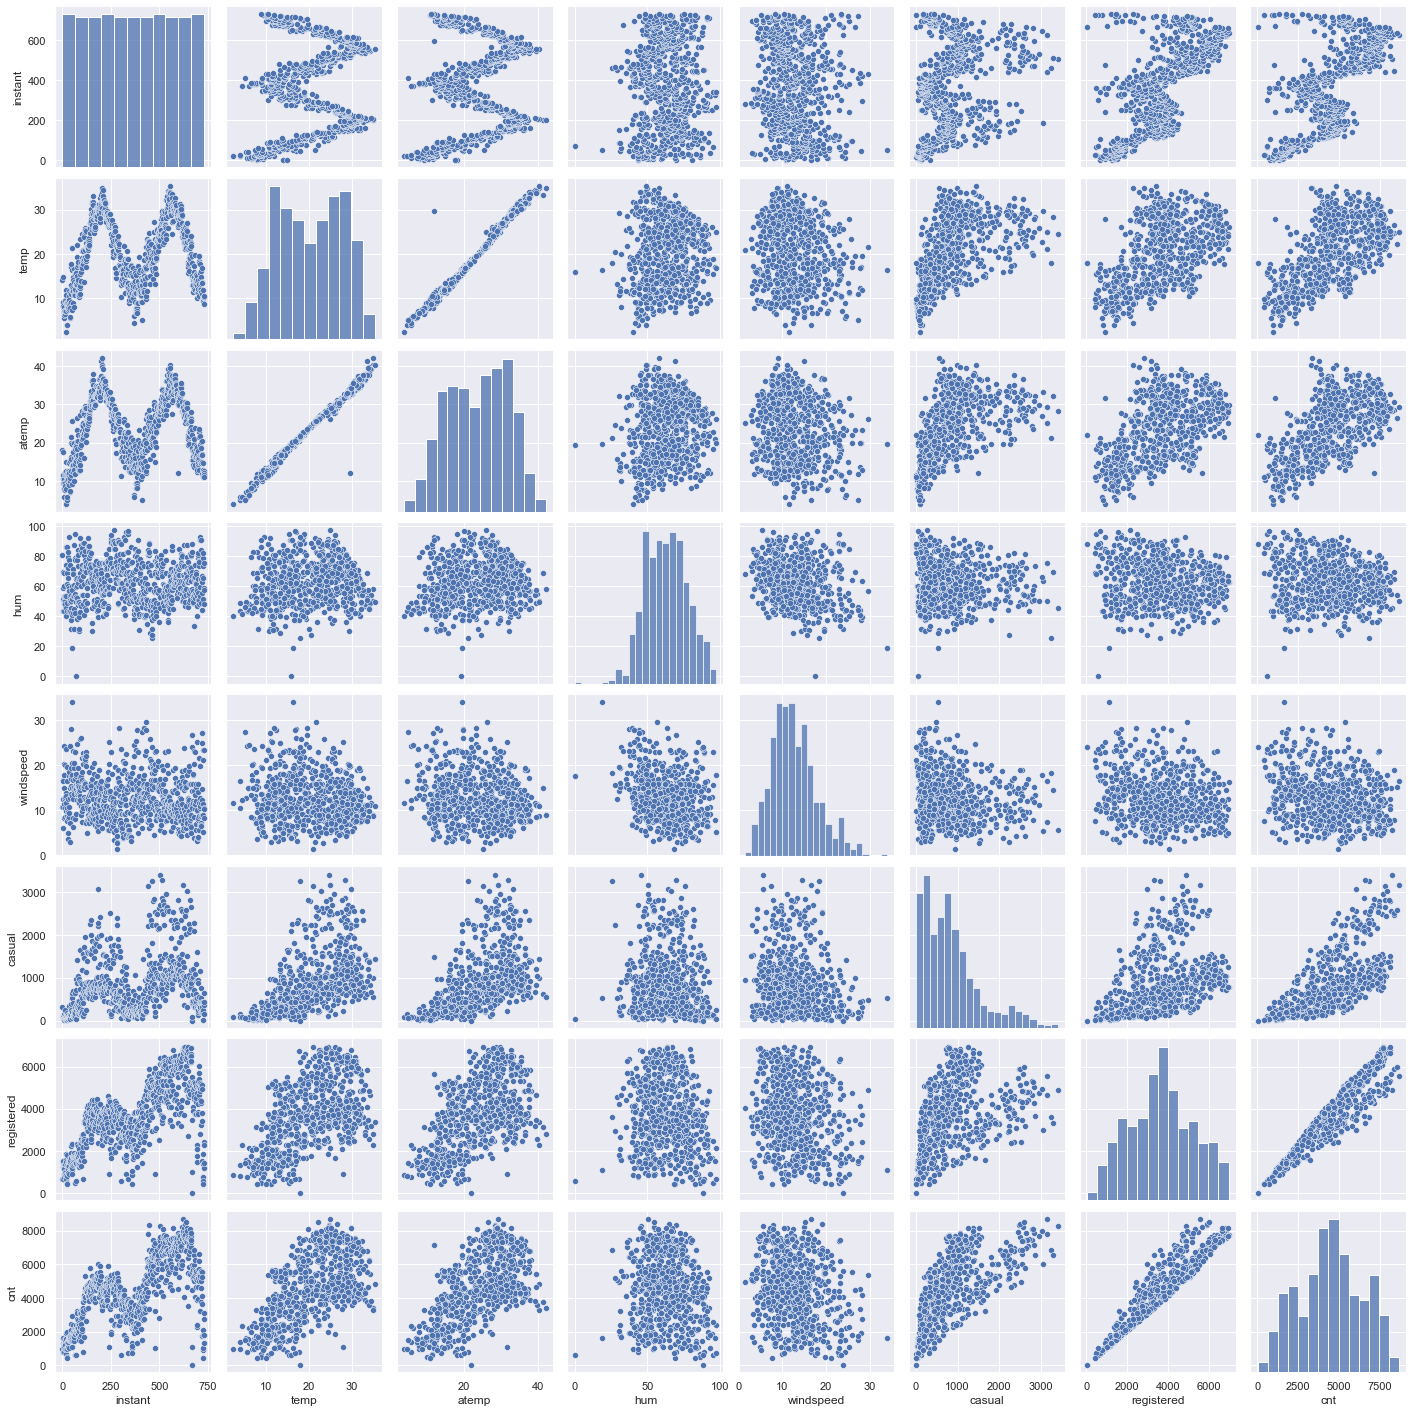

In [101]:
#pair plot of numeric variables 

num_vars = ['instant', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
sns.pairplot(boombikes[num_vars])
plt.show()

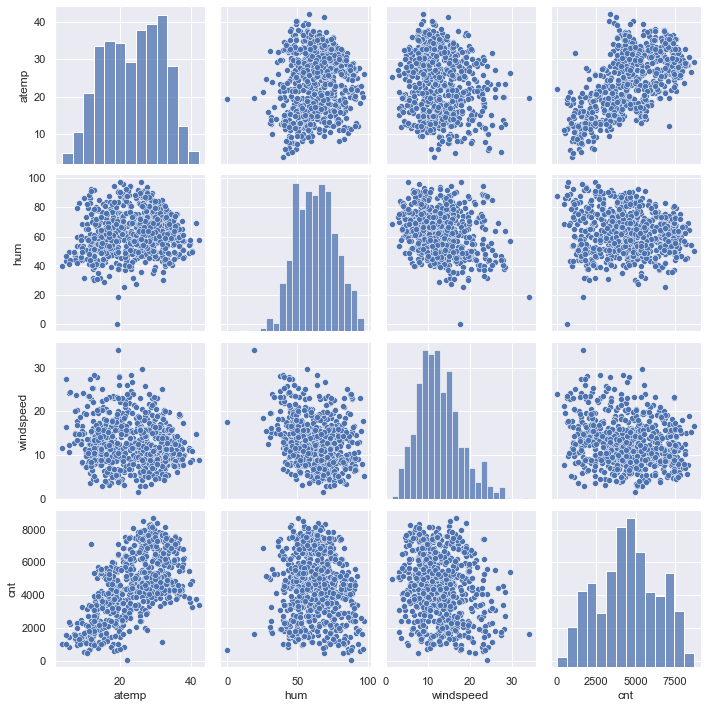

In [102]:
num_vars = ['atemp', 'hum', 'windspeed','cnt']
sns.pairplot(boombikes[num_vars])
plt.show()

**`Inferences`** - 
1) temp and atemp seems to have good linear relationship, one of them need to be dropped

2) casual and registered seems to have good positive correlated with cnt, as cnt is summation of them

3) Instant doesn't seem to show any good pattern with cnt therefore can be dropped

4) hum and windspeed tends to show some pattern however weak, but can be considered in model building



### Categorical analysis with target variable "cnt"

In [103]:
def box_plot(y_axis, x_axis, title, labels):
    width = len(boombikes[x_axis].unique())
    plt.figure(figsize=[width+5,8])
    plt.title(title, fontdict={'fontsize': 20, 'fontweight' : 20, 'color' : 'Green'})
    plt.xlabel(x_axis,fontdict={'fontsize': 17, 'fontweight' : 15, 'color' : 'black'})
    plt.ylabel( y_axis,fontdict={'fontsize': 15, 'fontweight' : 15, 'color' : 'black'})
    sns.barplot(y=y_axis, x=x_axis, data=boombikes)
    plt.xticks(np.arange(0,width),labels, rotation=45)
    plt.show()

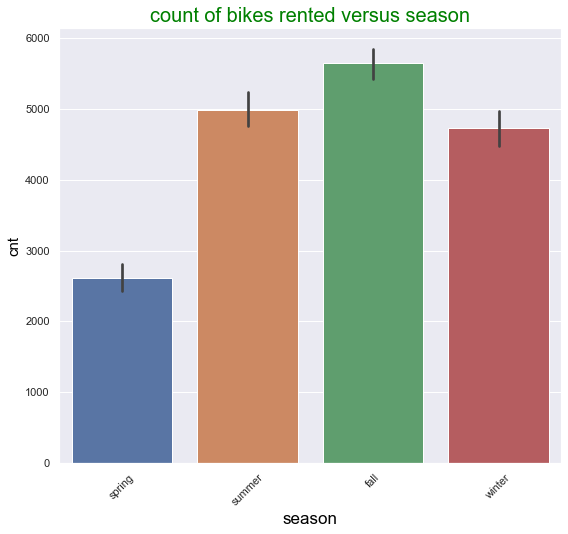

In [104]:
box_plot('cnt', 'season', 'count of bikes rented versus season', ["spring","summer", "fall","winter"])

**`Inferences`**- 
1) "spring" season - seems to have quite low count of rental bikes as compared to tht other three seasons

2) Maximum registrations are done in "fall" season

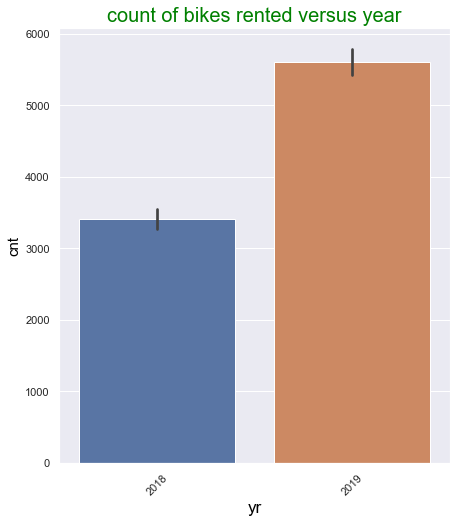

In [105]:
box_plot('cnt', 'yr', 'count of bikes rented versus year', ["2018","2019"])

**`Inferences`**- Total number of rental bikes seems to be higher for year 2019

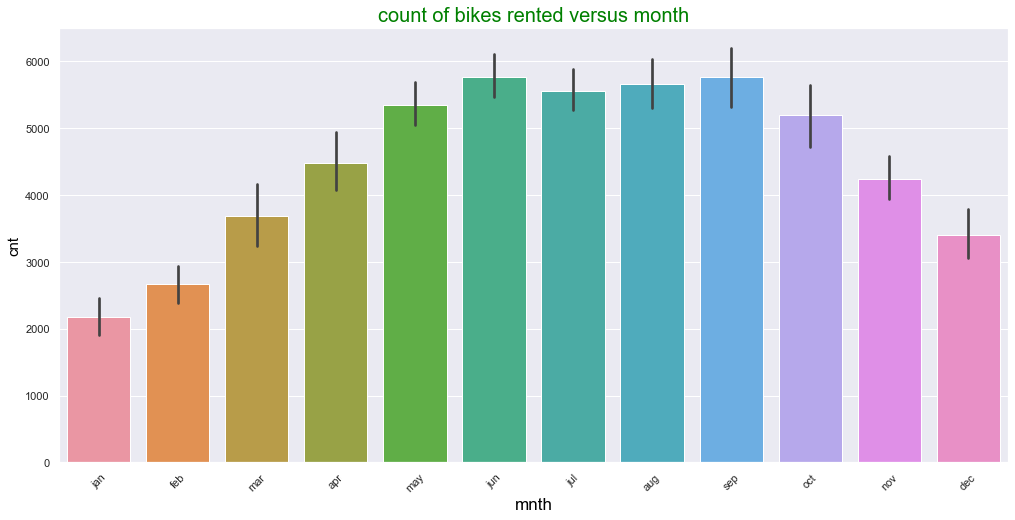

In [106]:
box_plot('cnt', 'mnth', 'count of bikes rented versus month', ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])

**`Inferences`**- 
1) Least count of rental bikes can be observed in months jan followed by feb.

2) aug, sep and oct seems to be the favorable months when most bikes are rented

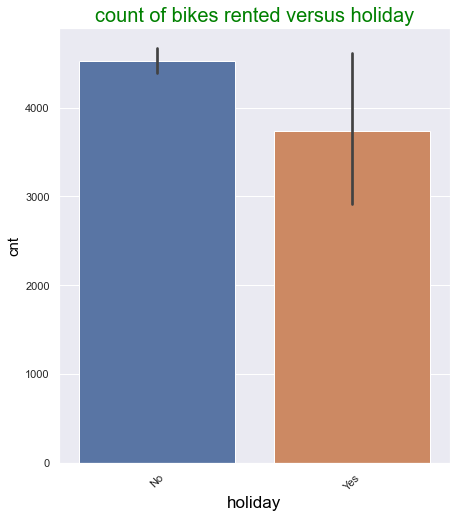

In [107]:
box_plot('cnt', 'holiday', 'count of bikes rented versus holiday', ['No','Yes'])

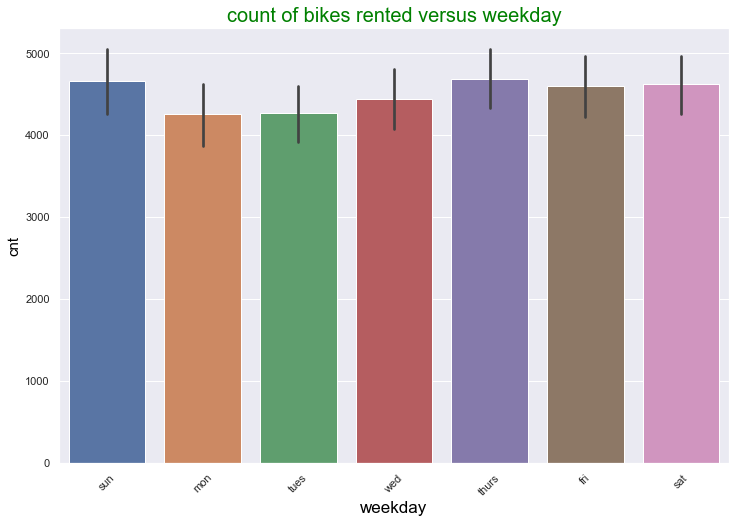

In [108]:
box_plot('cnt', 'weekday', 'count of bikes rented versus weekday',['sun','mon','tues','wed','thurs','fri','sat'])

**`Inferences`** - Much difference can't be observed in case of days of weeks, though most bikes are rented on sunday

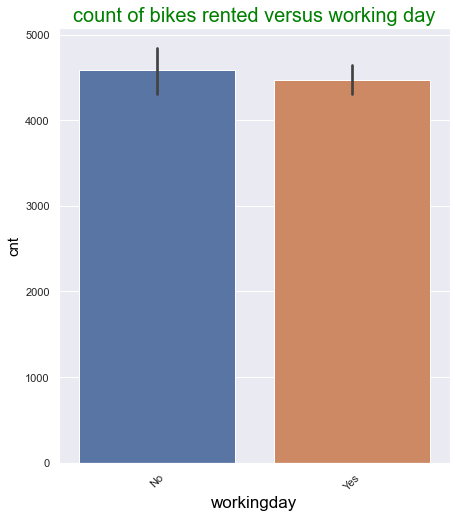

In [109]:
box_plot('cnt', 'workingday', 'count of bikes rented versus working day', ['No', 'Yes'])

**`Inferences`**- Almost equal number of bikes are rented on both working and non-working days

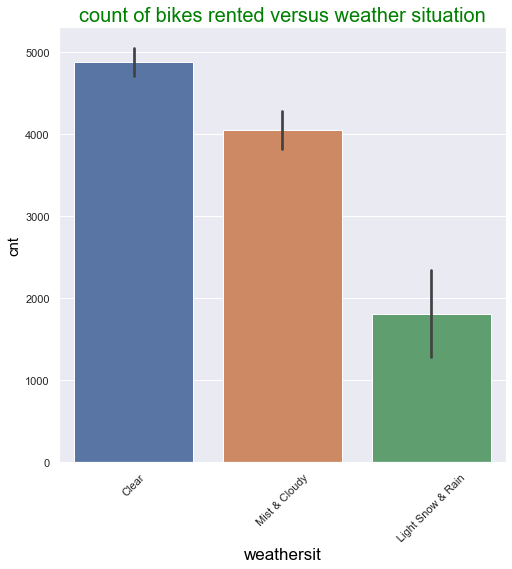

In [110]:
box_plot('cnt', 'weathersit', 'count of bikes rented versus weather situation', ["Clear", "Mist & Cloudy","Light Snow & Rain"])

 **`Inferences`** - It is quite clear from the plot that most of the bikes are rented when weather situation is clear.
 Also, least number can be observed in case of snow and rain.

# Step 2: Data Preparation

### 2.1 Drop unnecessary columns

i) "casual" is count of casual users and "registered" is count of registered users. Both should be dropped as they combine to create the "cnt" count of total bikes. It can be said "casual" and "registered" are also type of target variables. But as per our problem statement we only need "cnt".

ii) "isntant" and "dteday" doesn't seem to play an important role in variation of our target variable "cnt"(already observed in EDA above), therefore can be dropped

In [111]:
#dropping casual, registered, instant and dteday

boombikes.drop(['casual','registered','instant','dteday'], axis=1, inplace=True)

In [112]:
boombikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


### 2.2 Identify categorical, binary and continous variables and checking their data types

In [113]:
for col in boombikes.columns:
    print(col)
    print(boombikes[col].value_counts())

season
3    188
2    184
1    180
4    178
Name: season, dtype: int64
yr
1    365
0    365
Name: yr, dtype: int64
mnth
12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     56
Name: mnth, dtype: int64
holiday
0    709
1     21
Name: holiday, dtype: int64
weekday
2    105
1    105
6    104
5    104
4    104
3    104
0    104
Name: weekday, dtype: int64
workingday
1    504
0    226
Name: workingday, dtype: int64
weathersit
1    463
2    246
3     21
Name: weathersit, dtype: int64
temp
10.899153    5
26.035000    5
23.130847    4
28.563347    4
27.880000    4
            ..
27.025847    1
19.270000    1
13.191299    1
24.155847    1
5.526103     1
Name: temp, Length: 498, dtype: int64
atemp
32.73440    4
18.78105    3
31.85040    3
16.28750    2
17.58145    2
           ..
36.96315    1
24.93625    1
32.73460    1
14.82130    1
9.31250     1
Name: atemp, Length: 689, dtype: int64
hum
61.3333    4
69.7083    3
59.0000    3
57.0000    3
72.

Binary columns : yr, holiday, workingday -- already in int data type
Categorical Columns: season, mnth, weekday, weathersit -- need to be processed
Continous columns: temp, atemp, hum, windspeed

### 2.3 Converting numeric categories to textual categories

In [114]:
# trying to create dummies for season
pd.get_dummies(boombikes['season'])

#the categories doesn't seem to be informative enough with name

,1,2,3,4
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
725,1,0,0,0
726,1,0,0,0
727,1,0,0,0
728,1,0,0,0


In [115]:
#checking data types of categorical variables
boombikes[['season', 'mnth', 'weekday', 'weathersit']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   season      730 non-null    int64
 1   mnth        730 non-null    int64
 2   weekday     730 non-null    int64
 3   weathersit  730 non-null    int64
dtypes: int64(4)
memory usage: 22.9 KB


In [116]:
# Converting the values for categorical columns to texual categories with object dtype
# for get_dummies and to make the names more informative for the model

In [117]:
# season : (1:spring, 2:summer, 3:fall, 4:winter

boombikes.loc[(boombikes.season == 1),'season']='spring'


In [118]:
boombikes.loc[(boombikes.season == 2), 'season']='summer'
boombikes.loc[(boombikes.season == 3), 'season']='fall'
boombikes.loc[(boombikes.season == 4), 'season']='winter'

In [119]:
boombikes.season.value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [120]:
# weekday : 
boombikes.weekday.value_counts()

2    105
1    105
6    104
5    104
4    104
3    104
0    104
Name: weekday, dtype: int64

In [121]:
boombikes = boombikes.replace({'weekday':{1:'monday', 2:'tuesday', 3:'wednesday', 4:'thursday', 5:'friday', 6:'saturday', 0:'sunday'}})

In [122]:
boombikes.weekday.value_counts()

monday       105
tuesday      105
sunday       104
friday       104
saturday     104
thursday     104
wednesday    104
Name: weekday, dtype: int64

In [123]:
# mnth

boombikes.mnth.value_counts()


12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     56
Name: mnth, dtype: int64

In [124]:
boombikes = boombikes.replace({'mnth':{1:'jan', 2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul',8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'}})

In [125]:
boombikes.mnth.value_counts()

jan    62
jul    62
oct    62
mar    62
dec    62
may    62
aug    62
nov    60
sep    60
jun    60
apr    60
feb    56
Name: mnth, dtype: int64

In [126]:
# weathersit
boombikes.weathersit.value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [127]:
boombikes = boombikes.replace({'weathersit':{1:'clear', 2:'mist&cloudy', 3:'light_snow&rain', 4:'heavy_snow&rain'}})

In [128]:
boombikes.weathersit.value_counts()

clear              463
mist&cloudy        246
light_snow&rain     21
Name: weathersit, dtype: int64

### 2.4 Creating dummy variables

In [129]:
# creating dummies for season
seasons=pd.get_dummies(boombikes['season'], drop_first=True)
seasons.head()

,spring,summer,winter
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [130]:
boombikes = pd.concat([boombikes,seasons], axis=1)
boombikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,winter
0,spring,0,jan,0,monday,1,mist&cloudy,14.110847,18.18125,80.5833,10.749882,985,1,0,0
1,spring,0,jan,0,tuesday,1,mist&cloudy,14.902598,17.68695,69.6087,16.652113,801,1,0,0
2,spring,0,jan,0,wednesday,1,clear,8.050924,9.47025,43.7273,16.636703,1349,1,0,0
3,spring,0,jan,0,thursday,1,clear,8.200000,10.60610,59.0435,10.739832,1562,1,0,0
4,spring,0,jan,0,friday,1,clear,9.305237,11.46350,43.6957,12.522300,1600,1,0,0


In [131]:
boombikes.drop('season', axis=1, inplace=True)

In [132]:
boombikes.head()

,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,spring,summer,winter
0,0,jan,0,monday,1,mist&cloudy,14.110847,18.18125,80.5833,10.749882,985,1,0,0
1,0,jan,0,tuesday,1,mist&cloudy,14.902598,17.68695,69.6087,16.652113,801,1,0,0
2,0,jan,0,wednesday,1,clear,8.050924,9.47025,43.7273,16.636703,1349,1,0,0
3,0,jan,0,thursday,1,clear,8.200000,10.60610,59.0435,10.739832,1562,1,0,0
4,0,jan,0,friday,1,clear,9.305237,11.46350,43.6957,12.522300,1600,1,0,0


In [133]:
# creating dummies for mnth

months=pd.get_dummies(boombikes['mnth'], drop_first=True)
months.head()

,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep
0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0


In [134]:
boombikes = pd.concat([boombikes,months], axis=1)
boombikes.drop('mnth', axis=1, inplace=True)

In [135]:
boombikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   weekday     730 non-null    object 
 3   workingday  730 non-null    int64  
 4   weathersit  730 non-null    object 
 5   temp        730 non-null    float64
 6   atemp       730 non-null    float64
 7   hum         730 non-null    float64
 8   windspeed   730 non-null    float64
 9   cnt         730 non-null    int64  
 10  spring      730 non-null    uint8  
 11  summer      730 non-null    uint8  
 12  winter      730 non-null    uint8  
 13  aug         730 non-null    uint8  
 14  dec         730 non-null    uint8  
 15  feb         730 non-null    uint8  
 16  jan         730 non-null    uint8  
 17  jul         730 non-null    uint8  
 18  jun         730 non-null    uint8  
 19  mar         730 non-null    u

In [136]:
# creating dummies for weekday
weekdays=pd.get_dummies(boombikes['weekday'], drop_first=True)
weekdays.head()

,monday,saturday,sunday,thursday,tuesday,wednesday
0,1,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,1
3,0,0,0,1,0,0
4,0,0,0,0,0,0


In [137]:
boombikes = pd.concat([boombikes,weekdays], axis=1)
boombikes.drop('weekday', axis=1, inplace=True)

In [138]:
boombikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   holiday     730 non-null    int64  
 2   workingday  730 non-null    int64  
 3   weathersit  730 non-null    object 
 4   temp        730 non-null    float64
 5   atemp       730 non-null    float64
 6   hum         730 non-null    float64
 7   windspeed   730 non-null    float64
 8   cnt         730 non-null    int64  
 9   spring      730 non-null    uint8  
 10  summer      730 non-null    uint8  
 11  winter      730 non-null    uint8  
 12  aug         730 non-null    uint8  
 13  dec         730 non-null    uint8  
 14  feb         730 non-null    uint8  
 15  jan         730 non-null    uint8  
 16  jul         730 non-null    uint8  
 17  jun         730 non-null    uint8  
 18  mar         730 non-null    uint8  
 19  may         730 non-null    u

In [139]:
#creating dummies for weathersit

weather=pd.get_dummies(boombikes['weathersit'], drop_first=True)
weather.head()

,light_snow&rain,mist&cloudy
0,0,1
1,0,1
2,0,0
3,0,0
4,0,0


In [140]:
boombikes = pd.concat([boombikes,weather], axis=1)
boombikes.drop('weathersit', axis=1, inplace=True)

In [141]:
boombikes.info()
boombikes.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   yr               730 non-null    int64  
 1   holiday          730 non-null    int64  
 2   workingday       730 non-null    int64  
 3   temp             730 non-null    float64
 4   atemp            730 non-null    float64
 5   hum              730 non-null    float64
 6   windspeed        730 non-null    float64
 7   cnt              730 non-null    int64  
 8   spring           730 non-null    uint8  
 9   summer           730 non-null    uint8  
 10  winter           730 non-null    uint8  
 11  aug              730 non-null    uint8  
 12  dec              730 non-null    uint8  
 13  feb              730 non-null    uint8  
 14  jan              730 non-null    uint8  
 15  jul              730 non-null    uint8  
 16  jun              730 non-null    uint8  
 17  mar             

(730, 30)

### 2.5 Split into train and test data

In [142]:
df_train, df_test= train_test_split(boombikes, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 30)
(220, 30)


### 2.6 Rescaling of continous variables

In [143]:
# 1. Insatntiate the object
scaler = MinMaxScaler()

#create a list of numeric variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

#2.  Fit on data
df_train[num_vars]= scaler.fit_transform(df_train[num_vars])
df_train.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,light_snow&rain,mist&cloudy
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,0,0,0,0,1,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,0,1,0,0,0,0,1
728,1,0,1,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,0,0,1,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,0,1,0,0,0,0,1
111,0,0,0,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,...,0,0,0,0,1,0,0,0,0,1


In [144]:
df_train[num_vars].describe()

,temp,atemp,hum,windspeed,cnt
count,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.537440,0.513156,0.650480,0.320883,0.513499
std,0.225858,0.212410,0.145846,0.169803,0.224421
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.339853,0.332086,0.538643,0.199179,0.356420
50%,0.542596,0.529718,0.653714,0.296763,0.518638
75%,0.735215,0.688457,0.754830,0.414447,0.684710
max,1.000000,1.000000,1.000000,1.000000,1.000000


### 2.6 checking for correlations

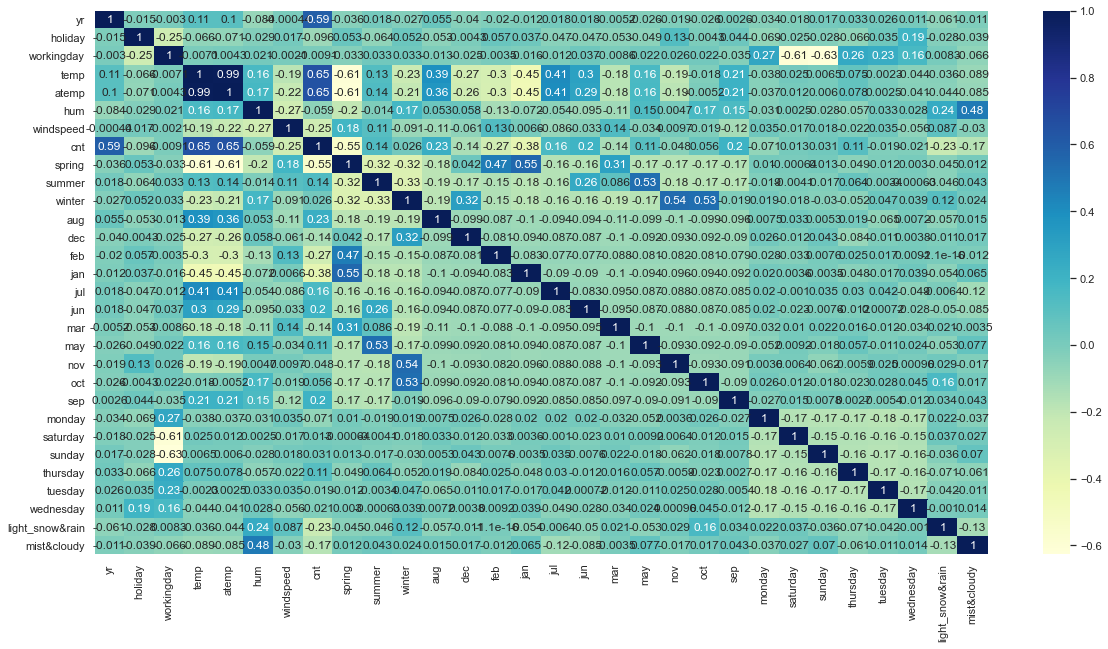

In [145]:
# heatmap

plt.figure(figsize = (20,10))
sns.heatmap(df_train.corr(), annot=True, cmap="YlGnBu")
plt.show()

**`Inferences`**- 
 atemp and temp are exceptionally highly correlated- one of them should be dropped


In [146]:
# on the basis of heatmap dropping 'temp' and continuing the analysis based on 'atemp'

df_train_new=df_train.drop('temp', axis=1)
df_train_new.columns

Index(['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'cnt',
       'spring', 'summer', 'winter', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun',
       'mar', 'may', 'nov', 'oct', 'sep', 'monday', 'saturday', 'sunday',
       'thursday', 'tuesday', 'wednesday', 'light_snow&rain', 'mist&cloudy'],
      dtype='object')

# Step 3. Building the Model

### 3.1 Divide into X and Y sets for model building

In [147]:
y_train = df_train_new.pop('cnt')
x_train = df_train_new

### 3.2 RFE (Recurrsive Feature Selection)

In [148]:
# running RFE with output number of variables equal to 15
lm = LinearRegression()
lm.fit(x_train, y_train)

rfe = RFE(lm, 15)
rfe = rfe.fit(x_train, y_train)

In [149]:
list(zip(x_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 2),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', False, 5),
 ('summer', True, 1),
 ('winter', True, 1),
 ('aug', True, 1),
 ('dec', True, 1),
 ('feb', True, 1),
 ('jan', True, 1),
 ('jul', False, 11),
 ('jun', False, 7),
 ('mar', False, 14),
 ('may', False, 6),
 ('nov', True, 1),
 ('oct', False, 12),
 ('sep', True, 1),
 ('monday', False, 9),
 ('saturday', False, 3),
 ('sunday', False, 4),
 ('thursday', False, 13),
 ('tuesday', False, 8),
 ('wednesday', False, 10),
 ('light_snow&rain', True, 1),
 ('mist&cloudy', True, 1)]

In [150]:
col = x_train.columns[rfe.support_] # RFE selected columns
col

Index(['yr', 'holiday', 'atemp', 'hum', 'windspeed', 'summer', 'winter', 'aug',
       'dec', 'feb', 'jan', 'nov', 'sep', 'light_snow&rain', 'mist&cloudy'],
      dtype='object')

In [151]:
x_train.columns[~rfe.support_]

Index(['workingday', 'spring', 'jul', 'jun', 'mar', 'may', 'oct', 'monday',
       'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday'],
      dtype='object')

### 3.3 Building model using statsmodel, for the detailed statistics

In [152]:
x_train_rfe = x_train[col]  # predictive variable set for first model

In [153]:
x_train_rfe.head()

,yr,holiday,atemp,hum,windspeed,summer,winter,aug,dec,feb,jan,nov,sep,light_snow&rain,mist&cloudy
576,1,0,0.766351,0.725633,0.264686,0,0,0,0,0,0,0,0,0,0
426,1,0,0.438975,0.640189,0.255342,0,0,0,0,0,0,0,0,0,1
728,1,0,0.200348,0.498067,0.663106,0,0,0,1,0,0,0,0,0,0
482,1,0,0.391735,0.504508,0.188475,1,0,0,0,0,0,0,0,0,1
111,0,0,0.318819,0.751824,0.380981,1,0,0,0,0,0,0,0,0,1


In [154]:
# function for model creation

def create_model(x_train_mod):
    x_train_sm = sm.add_constant(x_train_mod) # adding constant
    lr = sm.OLS(y_train, x_train_sm)   # running the linear model
    lr_model = lr.fit()
    return lr_model

In [155]:
# function for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
    
def VIF(x_train_vif):
    vif = pd.DataFrame()
    vif['Features'] = x_train_vif.columns
    vif['VIF'] = [variance_inflation_factor(x_train_vif.values, i) for i in range(x_train_vif.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by ='VIF', ascending=False)
    print(vif)


#### 1) First Model

In [156]:
lr_model_one = create_model(x_train_rfe)
print(lr_model_one.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     174.4
Date:                Mon, 10 May 2021   Prob (F-statistic):          2.92e-186
Time:                        21:45:04   Log-Likelihood:                 508.08
No. Observations:                 510   AIC:                            -984.2
Df Residuals:                     494   BIC:                            -916.4
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2931      0.032     

In [157]:
# p-value seems to be fine, below .05 for all the variables
# R-squared : .845 and Adjusted R-squared: 0.840 both are pretty high

In [158]:
# checking VIF Model 1
VIF(x_train_rfe)


           Features    VIF
3               hum  25.06
2             atemp  14.42
4         windspeed   3.90
6            winter   3.04
5            summer   2.29
14      mist&cloudy   2.24
0                yr   2.06
10              jan   1.92
11              nov   1.87
8               dec   1.64
7               aug   1.60
9               feb   1.55
12              sep   1.38
13  light_snow&rain   1.25
1           holiday   1.06


**`nov`**: little high p value
**`hum`** : with p-value 0.000 seems to be quite significant, but obsrving the VIF which is quite high - 25.06


#### 2) Second Model : dropping 'nov'

In [159]:

x_train_new=x_train_rfe.drop('nov', axis=1)

In [160]:
x_train_new.columns

Index(['yr', 'holiday', 'atemp', 'hum', 'windspeed', 'summer', 'winter', 'aug',
       'dec', 'feb', 'jan', 'sep', 'light_snow&rain', 'mist&cloudy'],
      dtype='object')

In [161]:
lr_model=create_model(x_train_new)
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     185.1
Date:                Mon, 10 May 2021   Prob (F-statistic):          2.25e-186
Time:                        21:45:04   Log-Likelihood:                 505.63
No. Observations:                 510   AIC:                            -981.3
Df Residuals:                     495   BIC:                            -917.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2793      0.031     

In [162]:
#Checking VIF

VIF(x_train_new)

           Features    VIF
3               hum  24.44
2             atemp  14.00
4         windspeed   3.84
6            winter   2.40
5            summer   2.27
13      mist&cloudy   2.22
0                yr   2.06
10              jan   1.88
7               aug   1.60
9               feb   1.52
8               dec   1.40
11              sep   1.36
12  light_snow&rain   1.24
1           holiday   1.05


**`dec`** - high p-value : .061

#### 3) Third Model with removed "dec"

In [163]:
x_train_new = x_train_new.drop('dec', axis=1)
x_train_new.columns

Index(['yr', 'holiday', 'atemp', 'hum', 'windspeed', 'summer', 'winter', 'aug',
       'feb', 'jan', 'sep', 'light_snow&rain', 'mist&cloudy'],
      dtype='object')

In [164]:
lr_model =create_model(x_train_new)
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     198.1
Date:                Mon, 10 May 2021   Prob (F-statistic):          8.93e-187
Time:                        21:45:04   Log-Likelihood:                 503.83
No. Observations:                 510   AIC:                            -979.7
Df Residuals:                     496   BIC:                            -920.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2654      0.030     

In [165]:
VIF(x_train_new)

           Features    VIF
3               hum  21.63
2             atemp  12.82
4         windspeed   3.83
6            winter   2.39
5            summer   2.20
12      mist&cloudy   2.19
0                yr   2.05
9               jan   1.77
7               aug   1.59
8               feb   1.46
10              sep   1.34
11  light_snow&rain   1.21
1           holiday   1.05


**`feb`**- insignificant - p-value: 0.134

#### 4) Fourth Model : dropping "feb"

In [166]:
x_train_new=x_train_new.drop('feb', axis=1)

In [167]:
lr_model=create_model(x_train_new)
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     213.9
Date:                Mon, 10 May 2021   Prob (F-statistic):          1.83e-187
Time:                        21:45:04   Log-Likelihood:                 502.67
No. Observations:                 510   AIC:                            -979.3
Df Residuals:                     497   BIC:                            -924.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2502      0.029     

In [168]:
VIF(x_train_new)

           Features    VIF
3               hum  18.52
2             atemp  11.47
4         windspeed   3.60
11      mist&cloudy   2.16
0                yr   2.04
6            winter   2.02
5            summer   1.96
7               aug   1.56
8               jan   1.54
9               sep   1.32
10  light_snow&rain   1.19
1           holiday   1.04


**`jan`**- p-value 0.024, lets try to remove it and check if better results can be gained


#### 5) Fifth Model : dropping "jan"

In [169]:
x_train_new = x_train_new.drop('jan', axis=1)

In [170]:
lr_model=create_model(x_train_new)
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     230.9
Date:                Mon, 10 May 2021   Prob (F-statistic):          1.49e-187
Time:                        21:45:04   Log-Likelihood:                 500.06
No. Observations:                 510   AIC:                            -976.1
Df Residuals:                     498   BIC:                            -925.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2306      0.027     

In [171]:
VIF(x_train_new)

           Features    VIF
3               hum  14.69
2             atemp   9.73
4         windspeed   3.58
10      mist&cloudy   2.13
0                yr   2.01
5            summer   1.84
6            winter   1.74
7               aug   1.55
8               sep   1.30
9   light_snow&rain   1.16
1           holiday   1.04


**`p-value`**- all p-values are achieved as zero
**`VIF`**- hum with high VIF 14.69, needs to be removed

#### 6) Sixth model: dropping "hum"

In [172]:
x_train_new = x_train_new.drop('hum', axis=1)
x_train_sm = sm.add_constant(x_train_new) # adding constant
lr = sm.OLS(y_train, x_train_sm)   # running the linear model
lr_model = lr.fit()
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     241.2
Date:                Mon, 10 May 2021   Prob (F-statistic):          6.05e-184
Time:                        21:45:04   Log-Likelihood:                 488.67
No. Observations:                 510   AIC:                            -955.3
Df Residuals:                     499   BIC:                            -908.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1275      0.017     

In [173]:
VIF(x_train_new)

          Features   VIF
2            atemp  4.92
3        windspeed  3.05
0               yr  2.00
4           summer  1.83
6              aug  1.55
5           winter  1.50
9      mist&cloudy  1.49
7              sep  1.30
8  light_snow&rain  1.08
1          holiday  1.04


**`Inferences`**- Model achieved with all variables having 0 p-value and all VIFs less than 5.
R-squared : 0.836
Ajusted R-squared: 0.832

Both R-squared and Ajusted R-squared are quite high to explain the model.

# Step 4: Residual analysis

In [174]:
# Residual analysis
lr_model

### 4.1 Calculating the Residuals and check distribution

In [175]:
y_train_pred = lr_model.predict(x_train_sm)


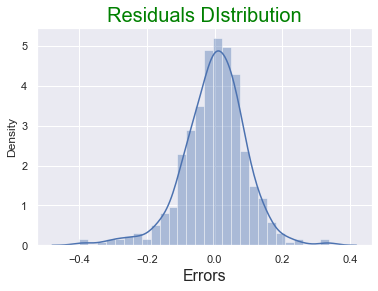

In [176]:
res = y_train-y_train_pred
plt.xlabel('Errors', fontsize=16)
plt.title("Residuals DIstribution", fontdict={'fontsize': 20, 'fontweight' : 20, 'color' : 'Green'})
sns.distplot(res)
plt.show()

**`Inference`**- The residual curve is centered around zero (mean = 0) and normally distributed. Therefore we can rely on this fit.

### 4.2 Checking for pattern in the residuals

In [177]:
x_train_sm_new = x_train_sm.drop(['const'], axis=1)

In [178]:
x_t = x_train_sm_new.iloc[:,0].values

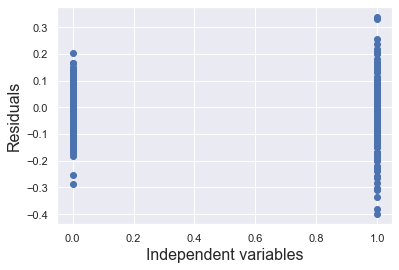

In [179]:
plt.xlabel("Independent variables", fontsize=16)
plt.ylabel("Residuals", fontsize=16)
plt.scatter(x_t,res)
plt.show()

**`Inference`**- There are no pattern so it is good.

# Step 5: Predictions and Final evaluation on Test set

In [180]:
#create a list of numeric variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

#2.  Fit on data
df_test[num_vars]= scaler.transform(df_test[num_vars])
df_test.head()


,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,light_snow&rain,mist&cloudy
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,...,0,0,0,0,0,0,0,1,0,1
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,1,...,0,0,0,0,0,1,0,0,0,0
299,0,0,0,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,1,0,0,1,0,0,0,0,0,1
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,0,0.817246,0.741471,0.314298,0.537414,0.569029,0,1,...,0,0,0,1,0,0,0,0,0,0


In [181]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,light_snow&rain,mist&cloudy
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.640909,0.558718,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,...,0.086364,0.086364,0.118182,0.172727,0.154545,0.140909,0.122727,0.159091,0.027273,0.318182
std,0.500809,0.187620,0.480828,0.233187,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,...,0.281541,0.281541,0.323559,0.378873,0.362295,0.348721,0.328872,0.366595,0.163248,0.466833
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [182]:
y_test = df_test.pop('cnt')
x_test = df_test

In [183]:
# add constant

x_test_sm = sm.add_constant(x_test)
x_test_sm.head()

,const,yr,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,...,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,light_snow&rain,mist&cloudy
184,1.0,0,1,0,0.831783,0.769660,0.657364,0.084219,0,0,...,0,0,0,0,0,0,0,1,0,1
535,1.0,1,0,1,0.901354,0.842587,0.610133,0.153728,0,1,...,0,0,0,0,0,1,0,0,0,0
299,1.0,0,0,0,0.511964,0.496145,0.837699,0.334206,0,0,...,1,0,0,1,0,0,0,0,0,1
221,1.0,0,0,1,0.881625,0.795343,0.437098,0.339570,0,0,...,0,0,0,0,0,0,0,0,0,0
152,1.0,0,0,0,0.817246,0.741471,0.314298,0.537414,0,1,...,0,0,0,1,0,0,0,0,0,0


In [184]:
x_test_sm = x_test_sm.drop(['temp','nov','dec','feb','jan','hum','workingday', 'spring', 'jul', 'jun', 'mar', 'may', 'oct', 'monday',
       'saturday', 'sunday', 'thursday', 'tuesday', 'wednesday'], axis=1)

In [185]:
x_test_sm.shape

(220, 11)

In [186]:
# predict

y_test_pred = lr_model.predict(x_test_sm)

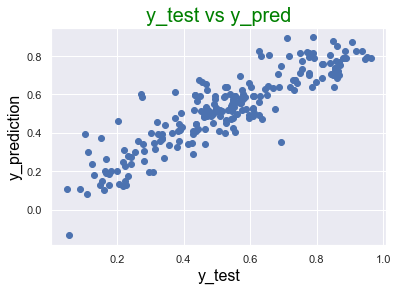

In [187]:
# y_test VS y_pred

sns.set_theme()
plt.title('y_test vs y_pred', fontdict={'fontsize': 20, 'fontweight' : 20, 'color' : 'Green'})
plt.xlabel('y_test', fontdict={'fontsize': 16, 'fontweight' : 20, 'color' : 'black'})
plt.ylabel('y_prediction', fontdict={'fontsize': 16, 'fontweight' : 20, 'color' : 'black'})
plt.scatter(y_test, y_test_pred)
plt.show()

In [188]:
# evaluating the R2 square for test data

r2_score(y_true=y_test, y_pred= y_test_pred)

0.79425209298371

**`Final Results`**-

R2 squared Train : 0.829

R2 squared Test : 0.794

Equation of best fitted line: y= m1x1 + m2x2 +...+mixi + c
    
**`   cnt = 0.2334 X yr - 0.0934 X holiday + 0.5370 X atemp - 0.1319 X windspeed + 0.0990 X summer + 0.1311 X winter 
           + 0.0679 X aug + 0.1209 X sep - 0.2760 X light_snow&rain - 0.0822 X mist&cloudy + 0.1275 `**

**`Inferences`**-
-  **atemp : feeling temperature in celcius** seems to have good positive correlation with count of rental bikes
-  mist and cloudy, light snow and rain are negatively correlated with count of rental bikes
-  windspeed and holiday are also negatively correlated with cnt(target variable)
-  yr, summer, winter, aug, sep are also positvely correlated